### 0. Import libraries

In [2]:
# Torch and Torchlightning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.nn.utils.rnn import pad_sequence

# Import Pytorch modules
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from torch.utils.tensorboard import SummaryWriter

# pytorch model summary 
from pytorch_model_summary import summary

# Sklearn for onehote encoding
from sklearn.preprocessing import LabelEncoder

# pandas
import pandas as pd

#Plotting tools 
import matplotlib.pyplot as plt

# some other utility modules
import random
import ast
import os

# Imports for SandiaPV
from pvlib import irradiance, temperature, pvsystem
from sandiapv_energy_prediction import *

C:\Users\denni\AppData\Local\Temp\ipykernel_13408\142410922.py:21: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. Define model

In [212]:
class EnergyPredictionModel(nn.Module):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size,num_layers, dropout_rate=0.1):
        super(EnergyPredictionModel, self).__init__()
        self.dynamic_rnn1 = nn.LSTM(input_size=dynamic_feature_size, hidden_size=hidden_size, batch_first=True)
        self.dynamic_rnn2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        
        # Increased depth in fully connected layers
        self.fc1 = nn.Linear(hidden_size + static_feature_size, 2*hidden_size)  
        self.fc2 = nn.Linear(2*hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 3)
        
        self.gelu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid() 

        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)
            
    def forward(self, dynamic_features, static_features):
        # Two LSTM layers
        output, _ = self.dynamic_rnn1(dynamic_features)
        output, (h_n, _) = self.dynamic_rnn2(output)
        h_n = h_n.squeeze(0)
        
        concatenated_features = torch.cat((h_n, static_features), dim=1)
        
        x = self.fc1(concatenated_features)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc3(x)

        output =  x #self.sigmoid(x)
        
        return output

## 2. Define training class


In [213]:
def calculate_gaussian_auc(amplitude, mean, std_dev):
    # Define a range of x values to compute the Gaussian function
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)
    std_dev = max(std_dev, 1e-6)
    gaussian_curve = amplitude * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))
    auc = np.trapz(gaussian_curve, x)
    return auc


class TrainEnergyPrediction(pl.LightningModule):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size, learning_rate, loss_type='mse', lambda_auc=1.0):
        super().__init__()
        self.save_hyperparameters()
        self.model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size, num_layers=3, dropout_rate=0.1)
        
        if loss_type == 'mse':
            self.loss_fn = nn.MSELoss(reduction='sum')
        elif loss_type == 'l1':
            self.loss_fn = nn.L1Loss(reduction='sum')
        elif loss_type == 'nll':
            self.loss_fn = nn.NLLLoss(reduction='sum')
        elif loss_type == 'huber':
            self.loss_fn = nn.HuberLoss(reduction='sum', delta=1.0)
        else:
            raise ValueError("Unsupported loss type. Choose from 'mse', 'l1', 'nll'.")
        
        self.train_losses = []
        self.validation_losses = []
        self.avg_train_losses = []
        self.avg_validation_losses = []
        self.test_losses = []
        self.delta_auc_errors = []
        self.learning_rate = learning_rate
        self.lambda_auc = lambda_auc

    def forward(self, x_dynamic, x_static):
        return self.model(x_dynamic, x_static)

    def calculate_delta_auc(self, y_pred, y_true):
        y_pred = y_pred.detach().cpu().numpy()
        y_true = y_true.detach().cpu().numpy()
        delta_aucs = []
        
        for i in range(len(y_true)):
            pred_auc = calculate_gaussian_auc(*y_pred[i])
            true_auc = calculate_gaussian_auc(*y_true[i])
            delta_aucs.append((pred_auc, true_auc))
        
        return delta_aucs

    def combined_loss(self, y_pred, y_true, pred_aucs, true_aucs):
        param_loss = self.loss_fn(y_pred, y_true)
        auc_loss = self.loss_fn(torch.tensor(pred_aucs, dtype=torch.float32, device=y_pred.device), 
                                torch.tensor(true_aucs, dtype=torch.float32, device=y_pred.device))
        total_loss = param_loss + self.lambda_auc * auc_loss
        return total_loss

    def training_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        aucs = self.calculate_delta_auc(y_pred.float(), y_true)
        pred_aucs, true_aucs = zip(*aucs)
        loss = self.combined_loss(y_pred, y_true, list(pred_aucs), list(true_aucs))
        self.log('train_loss', loss)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        aucs = self.calculate_delta_auc(y_pred.float(), y_true)
        pred_aucs, true_aucs = zip(*aucs)
        val_loss = self.combined_loss(y_pred, y_true, list(pred_aucs), list(true_aucs))
        
        self.log('val_loss', val_loss)
        self.validation_losses.append(val_loss.item())        
        return val_loss
    
    def test_step(self, batch, batch_idx, dataloader_idx=0):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        aucs = self.calculate_delta_auc(y_pred.float(), y_true)
        pred_aucs, true_aucs = zip(*aucs)
        param_loss = self.loss_fn(y_pred, y_true)
        auc_loss = self.loss_fn(torch.tensor(pred_aucs, dtype=torch.float32, device=y_pred.device), 
                                torch.tensor(true_aucs, dtype=torch.float32, device=y_pred.device))
        total_loss = param_loss + self.lambda_auc * auc_loss

        # Log metrics with dataloader index to differentiate between dataloaders
        self.log(f'total_loss', total_loss)
        self.log(f'param_loss', param_loss)
        self.log(f'auc_loss', auc_loss)

        return {'loss': total_loss, 'param_loss': param_loss, 'auc_loss': auc_loss}

    def predict(self, x_dynamic, x_static):
        return self.model(x_dynamic, x_static)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer



<style>
div.cell, div.input_area, div.output_area {
    background-color: #f0f0f0; /* Light grey color */
}
</style>

## 3. Load dataset

In [214]:
CONVERTER = {
    'temperature_sequence': ast.literal_eval, 
    'wind_speed_sequence': ast.literal_eval, 
    'dni_sequence': ast.literal_eval, 
    'dhi_sequence': ast.literal_eval, 
    'global_irradiance_sequence': ast.literal_eval, 
    'gaussian_params': lambda x: [float(i) for i in x.strip('[]').split()]
}

class SolarPanelDataset(Dataset):
    def __init__(self, synthetic_csv, measurement_csv, transform=None, sequence_length=24):
        self.sequence_length = sequence_length
        self.mean = []
        self.std =[]
        self.dynamic_cols = ['temperature_sequence', 'wind_speed_sequence', 'dni_sequence', 'dhi_sequence', 'global_irradiance_sequence']
        self.static_cols = ['tilt', 'azimuth' ]   
        self.features = self.dynamic_cols + self.static_cols 
        
        # Load data from both CSVs
        self.synthetic_data = pd.read_csv(synthetic_csv, converters=CONVERTER)  
        self.measurement_data = pd.read_csv(measurement_csv, converters=CONVERTER) 
        
        # Optionally apply transformations/pre-processing
        self.transform = transform
        
        # Combine data for easy shuffling and splitting
        self.synthetic_data['data_type'] = 'synthetic'
        self.measurement_data['data_type'] = 'measurement'
        self.data_frame = pd.concat([self.synthetic_data, self.measurement_data], ignore_index=True)
        
        # Encode string to int
        self.data_frame['module_type'] = LabelEncoder().fit_transform(self.data_frame['module_type'])
        
        # Ensure all sequences are of the same length
        self.pad_or_truncate_sequences()

        # Normalize features
        self.normalize_features()

        # Normalize outputs
        self.normalize_outputs()
        
    def pad_or_truncate_sequences(self):
        dynamic_cols = ['temperature_sequence', 'wind_speed_sequence', 'dni_sequence', 'dhi_sequence', 'global_irradiance_sequence']
        for col in dynamic_cols:
            self.data_frame[col] = self.data_frame[col].apply(self.pad_or_truncate)

    def pad_or_truncate(self, sequence):
        if len(sequence) > self.sequence_length:
            return sequence[:self.sequence_length]
        elif len(sequence) < self.sequence_length:
            return sequence + [0.0] * (self.sequence_length - len(sequence))
        return sequence

    def normalize_features(self):
        # Normalize static numeric features
        for feature in self.static_cols:
            mean = self.data_frame[feature].mean()
            self.mean.append(mean)
            std = self.data_frame[feature].std()
            self.std.append(std)
            if std > 0:
                self.data_frame[feature] = (self.data_frame[feature] - mean) / std
            else:
                self.data_frame[feature] = 0  

        # Normalizing dynamic features
        for col in self.dynamic_cols:
            col_data = np.concatenate(self.data_frame[col].values)
            mean = col_data.mean()
            self.mean.append(mean)
            std = col_data.std()
            self.std.append(std)
            if std > 0:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: (np.array(x) - mean) / std)
            else:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: np.zeros_like(x))  

    def normalize_outputs(self):
        # Normalize Gaussian output parameters using min-max scaling
        gaussian_array = np.array(self.data_frame['gaussian_params'].tolist())
        self.output_mins = gaussian_array.min(axis=0)
        self.output_maxs = gaussian_array.max(axis=0)

        # Avoid division by zero in case max == min
        range = self.output_maxs - self.output_mins
        range[range == 0] = 1  # prevent division by zero

        normalized_gaussian = (gaussian_array - self.output_mins) / range
        self.data_frame['gaussian_params'] = list(normalized_gaussian)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Static features
        static_features = self.data_frame.iloc[idx][['tilt', 'azimuth', 'module_type']].astype(np.float32).to_numpy()
        static_features = torch.tensor(static_features, dtype=torch.float32)
         
        # Dynamic features
        dynamic_features = np.array([
            self.data_frame.iloc[idx]['temperature_sequence'],
            self.data_frame.iloc[idx]['wind_speed_sequence'],
            self.data_frame.iloc[idx]['dni_sequence'],
            self.data_frame.iloc[idx]['dhi_sequence'],
            self.data_frame.iloc[idx]['global_irradiance_sequence']
        ]).astype(np.float32)
        dynamic_features = torch.tensor(dynamic_features, dtype=torch.float32)

        # Transpose to get shape (sequence_length, number_of_features)
        dynamic_features = dynamic_features.T

        # Gaussian parameters as output, normalized
        outputs = torch.tensor(self.data_frame.iloc[idx]['gaussian_params'], dtype=torch.float32)

        return dynamic_features, static_features, outputs

    def denormalize_output(self, normalized_output):
        # Convert normalized output back to original scale
        denormalized_output = normalized_output * (self.output_maxs - self.output_mins) + self.output_mins
        return denormalized_output

In [215]:
def create_data_loaders(dataset, synthetic_sampling_ratio, measured_split_ratio, synthetic_split_ratio, val_ratio, batch_size):
    # Split dataset into synthetic and measured data
    synthetic_indices = [i for i in range(len(dataset)) if dataset.data_frame.iloc[i]['data_type'] == 'synthetic']
    measured_indices = [i for i in range(len(dataset)) if dataset.data_frame.iloc[i]['data_type'] == 'measurement']

    print('size of the total dataset:', len(dataset), '\n'
          'size of synthetic data:', len(synthetic_indices), f'= {len(synthetic_indices)/len(dataset):.2f}\n' 
          'size of the measured data:', len(measured_indices), f'= {len(measured_indices)/len(dataset):.2f}\n')
    
    total_synthetic_count = int(synthetic_sampling_ratio * len(synthetic_indices))
    total_measured_count = len(measured_indices)

    print('size of the total dataset after subsampling:', total_synthetic_count + total_measured_count, '\n',
          'Size of synthetic data:', total_synthetic_count, f'= {total_synthetic_count / (total_synthetic_count + total_measured_count):.2f} \n', 
          'Size of the measured data:', total_measured_count, f'= {total_measured_count / (total_synthetic_count + total_measured_count):.2f} \n',
          '________________________________________________________\n')
    
    synthetic_data = Subset(dataset, synthetic_indices[:total_synthetic_count])
    measured_data = Subset(dataset, measured_indices[:total_measured_count])

    # Split synthetic data into training, validation, and testing
    synthetic_train_count = int(synthetic_split_ratio * total_synthetic_count)
    synthetic_val_count = int(val_ratio * synthetic_train_count)
    synthetic_train_count -= synthetic_val_count
    synthetic_test_count = total_synthetic_count - synthetic_train_count - synthetic_val_count

    synthetic_train_data, synthetic_val_data, synthetic_test_data = random_split(
        synthetic_data, [synthetic_train_count, synthetic_val_count, synthetic_test_count])

    # Split measured data into training, validation, and testing
    measured_train_count = int(measured_split_ratio * total_measured_count)
    measured_val_count = int(val_ratio * measured_train_count)
    measured_train_count -= measured_val_count
    measured_test_count = total_measured_count - measured_train_count - measured_val_count

    measured_train_data, measured_val_data, measured_test_data = random_split(
        measured_data, [measured_train_count, measured_val_count, measured_test_count])

    # Combine training and validation data
    train_data = measured_train_data + synthetic_train_data
    val_data = measured_val_data + synthetic_val_data

    print('Training set size (synthetic):', synthetic_train_count, 
          f'= {synthetic_train_count / total_synthetic_count:.2f} of synthetic data')
    print('Training set size (measured):', measured_train_count, 
          f'= {measured_train_count / total_measured_count:.2f} of measured data \n')
    print('Validation set size (synthetic):', synthetic_val_count, 
          f'= {synthetic_val_count / total_synthetic_count:.2f} of synthetic data')
    print('Validation set size (measured):', measured_val_count, 
          f'= {measured_val_count / total_measured_count:.2f} of measured data \n')
    print('Test set size (synthetic):', synthetic_test_count, 
          f'= {synthetic_test_count / total_synthetic_count:.2f} of synthetic data')
    print('Test set size (measured):', measured_test_count, 
          f'= {measured_test_count / total_measured_count:.2f} of measured data \n')

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)
    test_synthetic_loader = DataLoader(synthetic_test_data, batch_size=batch_size, shuffle=False, num_workers=0)
    test_measurement_loader = DataLoader(measured_test_data, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_synthetic_loader, test_measurement_loader

In [216]:
dataset = SolarPanelDataset('energy_data/dataset_to_train_model2.csv', 'energy_data/merged_solar_weather_data2.csv')

# Parameters
BATCHSIZE = 64

# Assuming dataset is already defined
train_loader, val_loader, test_synthetic_loader, test_measurement_loader = create_data_loaders(
    dataset,
    synthetic_sampling_ratio=1,  # 30% of the synthetic dataset
    measured_split_ratio=0.5,      # 50% of the measured dataset for training
    synthetic_split_ratio=0.7,     # 70% of the synthetic dataset for training
    val_ratio=0.2,                 # 10% of the training data for validation
    batch_size=BATCHSIZE
)

# Example of iterating through the train loader
for i, data in enumerate(train_loader):
    if i > 1:
        break
    dynamic_inputs, static_inputs, outputs = data
    print("Static Inputs:", static_inputs) # Panel type, tilt, azimuth, module type
    print("Dynamic Inputs Shape:", dynamic_inputs.shape) # Temperature, Wind, dni, dhi, global irradiance
    print("Outputs:", outputs) # Gaussian: Amplitude, Mean, standard deviation (normalized)

size of the total dataset: 12750 
size of synthetic data: 12497 = 0.98
size of the measured data: 253 = 0.02

size of the total dataset after subsampling: 12750 
 Size of synthetic data: 12497 = 0.98 
 Size of the measured data: 253 = 0.02 
 ________________________________________________________

Training set size (synthetic): 6998 = 0.56 of synthetic data
Training set size (measured): 101 = 0.40 of measured data 

Validation set size (synthetic): 1749 = 0.14 of synthetic data
Validation set size (measured): 25 = 0.10 of measured data 

Test set size (synthetic): 3750 = 0.30 of synthetic data
Test set size (measured): 127 = 0.50 of measured data 

Static Inputs: tensor([[ 0.8838, -0.0651,  0.0000],
        [-1.8392,  0.5988,  0.0000],
        [ 0.0276,  1.1155,  0.0000],
        [-0.9526, -0.0890,  0.0000],
        [ 2.0813, -1.4569,  0.0000],
        [ 0.9153,  0.1207,  0.0000],
        [ 0.1892, -0.7120,  0.0000],
        [ 1.1074,  1.3734,  0.0000],
        [-1.1439,  0.9114,  0.0

## 4. Train model

In [217]:
# Initialize the model
dynamic_feature_size = 5
static_feature_size = 3
hidden_size = 256 #
learning_rate = 0.0002396751332629912# 1e-3
epochs = 5 

# Initialize the Lightning module  
train_module = TrainEnergyPrediction(dynamic_feature_size,static_feature_size,hidden_size, learning_rate, loss_type='l1', lambda_auc=0.4)
model = train_module.model 
print(model)

EnergyPredictionModel(
  (dynamic_rnn1): LSTM(5, 256, batch_first=True)
  (dynamic_rnn2): LSTM(256, 256, batch_first=True)
  (fc1): Linear(in_features=259, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
  (gelu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (sigmoid): Sigmoid()
)


In [218]:
# Set up TensorBoard logger
log_dir = "tb_logs/my_model"
print("Log directory contents:", os.listdir(log_dir))
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=epochs, logger =logger)
    
# Fit the model to the training data
trainer.fit(train_module, train_dataloaders=train_loader,val_dataloaders=val_loader)
trained_model = train_module.model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 1.1 M 
1 | loss_fn | L1Loss                | 0     
--------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.243     Total estimated model params size (MB)


Log directory contents: ['version_10', 'version_100', 'version_101', 'version_102', 'version_103', 'version_104', 'version_105', 'version_106', 'version_107', 'version_108', 'version_109', 'version_11', 'version_110', 'version_111', 'version_112', 'version_113', 'version_114', 'version_115', 'version_116', 'version_117', 'version_118', 'version_119', 'version_12', 'version_120', 'version_121', 'version_122', 'version_123', 'version_124', 'version_125', 'version_126', 'version_127', 'version_128', 'version_129', 'version_13', 'version_130', 'version_131', 'version_132', 'version_133', 'version_134', 'version_135', 'version_136', 'version_137', 'version_138', 'version_139', 'version_14', 'version_140', 'version_141', 'version_142', 'version_143', 'version_144', 'version_145', 'version_146', 'version_147', 'version_148', 'version_149', 'version_15', 'version_150', 'version_151', 'version_152', 'version_153', 'version_154', 'version_155', 'version_156', 'version_157', 'version_158', 'versi

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## 5. Inspect performance

[55.773475646972656, 50.6727294921875, 46.82394790649414, 40.54154968261719, 37.32187271118164, 34.88745880126953, 30.016260147094727, 24.354990005493164, 20.358701705932617, 20.58672332763672, 20.48291778564453, 20.679773330688477, 24.028392791748047, 23.581573486328125, 23.6350040435791, 21.26633644104004, 19.179834365844727, 20.876487731933594, 17.854448318481445, 17.284954071044922, 18.725488662719727, 20.711267471313477, 19.572284698486328, 19.492717742919922, 18.699615478515625, 17.427770614624023, 16.319345474243164, 19.38523292541504, 17.668851852416992, 14.897793769836426, 16.09772491455078, 16.741220474243164, 18.734161376953125, 16.77336883544922, 17.735492706298828, 16.862560272216797, 16.438753128051758, 19.859230041503906, 15.75582504272461, 16.676420211791992, 15.084460258483887, 16.728626251220703, 16.183374404907227, 17.243844985961914, 15.312813758850098, 15.155759811401367, 14.6585693359375, 17.19297981262207, 15.58213996887207, 14.378450393676758, 13.677152633666992

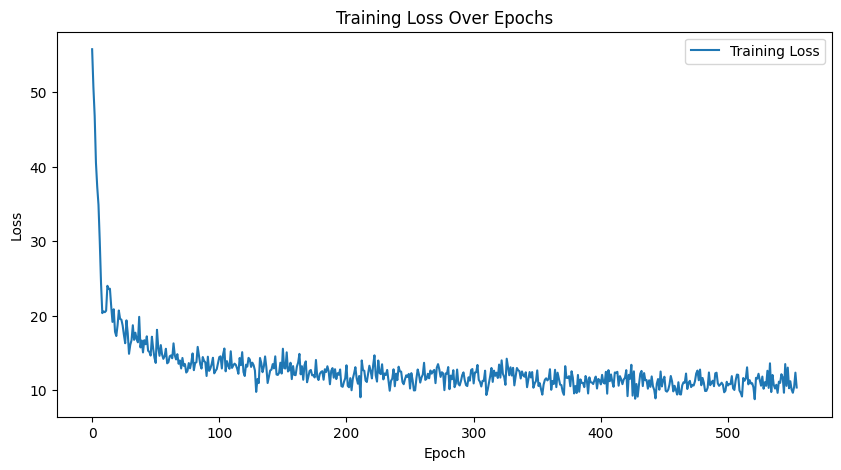

In [219]:
print(train_module.train_losses)
# After training
plt.figure(figsize=(10, 5))
plt.plot(train_module.train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# for i in  train_module.train_losses:
#     print(i)


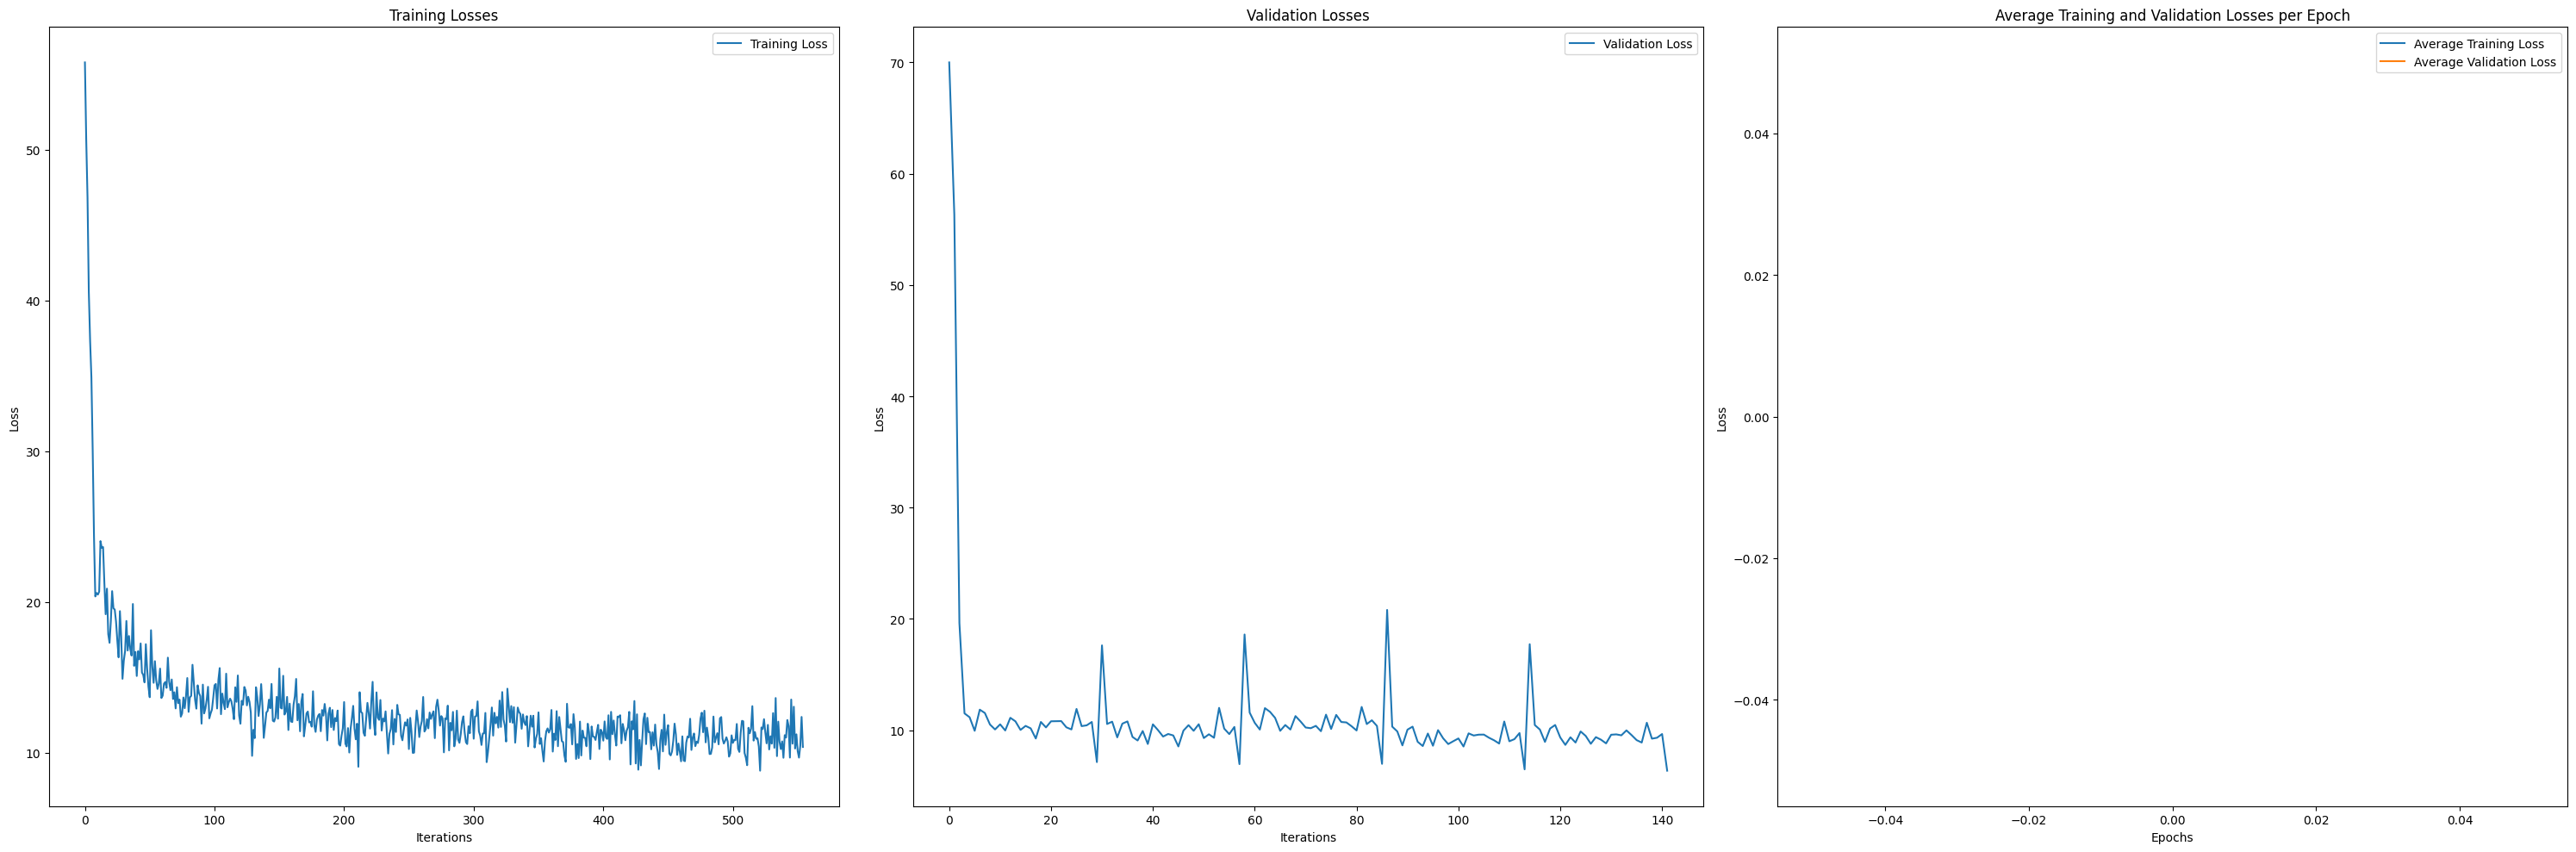

In [220]:
def plot_losses(train_losses, val_losses, avg_train_losses, avg_validation_losses):
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))

    # Plot all training losses
    axs[0].plot(train_losses, label='Training Loss')
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Losses')
    axs[0].legend()

    # Plot all validation losses
    axs[1].plot(val_losses, label='Validation Loss')
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Validation Losses')
    axs[1].legend()

    # Plot average losses at the end of each epoch
    axs[2].plot(avg_train_losses, label='Average Training Loss')
    axs[2].plot(avg_validation_losses, label='Average Validation Loss')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Loss')
    axs[2].set_title('Average Training and Validation Losses per Epoch')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# Assuming you have already trained the model and have the losses logged
plot_losses(train_module.train_losses, train_module.validation_losses, train_module.avg_train_losses, train_module.avg_validation_losses)

#### Launch tensorboard for advanced training insights

In [12]:
# #Launch tensorboard for advanced training insights.
# os.system(f"taskkill /pid 19988 /F")

# # Reload the TensorBoard extension to avoid errors about it being already loaded
# %reload_ext tensorboard

# # Start TensorBoard
# %tensorboard --logdir tb_logs/my_model

## Test model

In [221]:

# Assuming you have two dataloaders initialized

dataloaders = [test_synthetic_loader, test_measurement_loader]
dataloader_idx = [0,1]
trainer.test(train_module, dataloaders=dataloaders)

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         auc_loss          │    0.5628528594970703     │    18.728242874145508     │
│        param_loss         │     9.103398323059082     │    21.848087310791016     │
│        total_loss         │     9.328539848327637     │    29.339384078979492     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'total_loss/dataloader_idx_0': 9.328539848327637,
  'param_loss/dataloader_idx_0': 9.103398323059082,
  'auc_loss/dataloader_idx_0': 0.5628528594970703},
 {'total_loss/dataloader_idx_1': 29.339384078979492,
  'param_loss/dataloader_idx_1': 21.848087310791016,
  'auc_loss/dataloader_idx_1': 18.728242874145508}]

### Inference with tested model

In [222]:
# # Load the trained model
# trained_model = train_module 
# trained_model.eval() 

# # Get a single sample from the data loader
# sample_dynamic, sample_static, ground_truth = next(iter(test_measurement_loader))
# sample =1
# # Predict using a single example
# with torch.no_grad():
#     predictions = trained_model(sample_dynamic[sample].unsqueeze(0), sample_static[sample].unsqueeze(0))
# print(predictions,predictions.shape)

# # Define the Gaussian function
# def gaussian(x, a, b, c):
#     return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# # Function to plot Gaussian curves
# def plot_gaussian(x, predictions,ground_truth, labels):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     for i, label in enumerate(labels):
#         a, b, c = predictions[i]
#         y = gaussian(x, a, b, c)
#         ax.plot(x, y, label=f'{label} - Mean: {b:.2f}, Std Dev: {c:.2f}, Amp: {a:.2f}')
    
#      # Plot ground truth Gaussian curves
#     gt_a, gt_b, gt_c = ground_truth[0]
#     gt_y = gaussian(x, gt_a, gt_b, gt_c)
#     ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
    

#     ax.set_title('Gaussian Curves for Predicted Outputs')
#     ax.set_xlabel('X-axis')
#     ax.set_ylabel('Gaussian Value')
#     ax.legend()
#     plt.show()

# # Prepare x-axis for the plot
# x_values = np.linspace(-12, 12, 400)

# # Reshape predictions if necessary and convert to numpy if still in tensor form
# predictions = predictions.squeeze().numpy().reshape(1, -1)
# predictions = predictions
# print(predictions, predictions.shape)
# ground_truth = ground_truth[sample].squeeze().numpy().reshape(1, -1)
# # Plot the Gaussian curve for the predicted values
# plot_gaussian(x_values, predictions,ground_truth, labels=["Prediction 1"])

#### Test on synthetic data

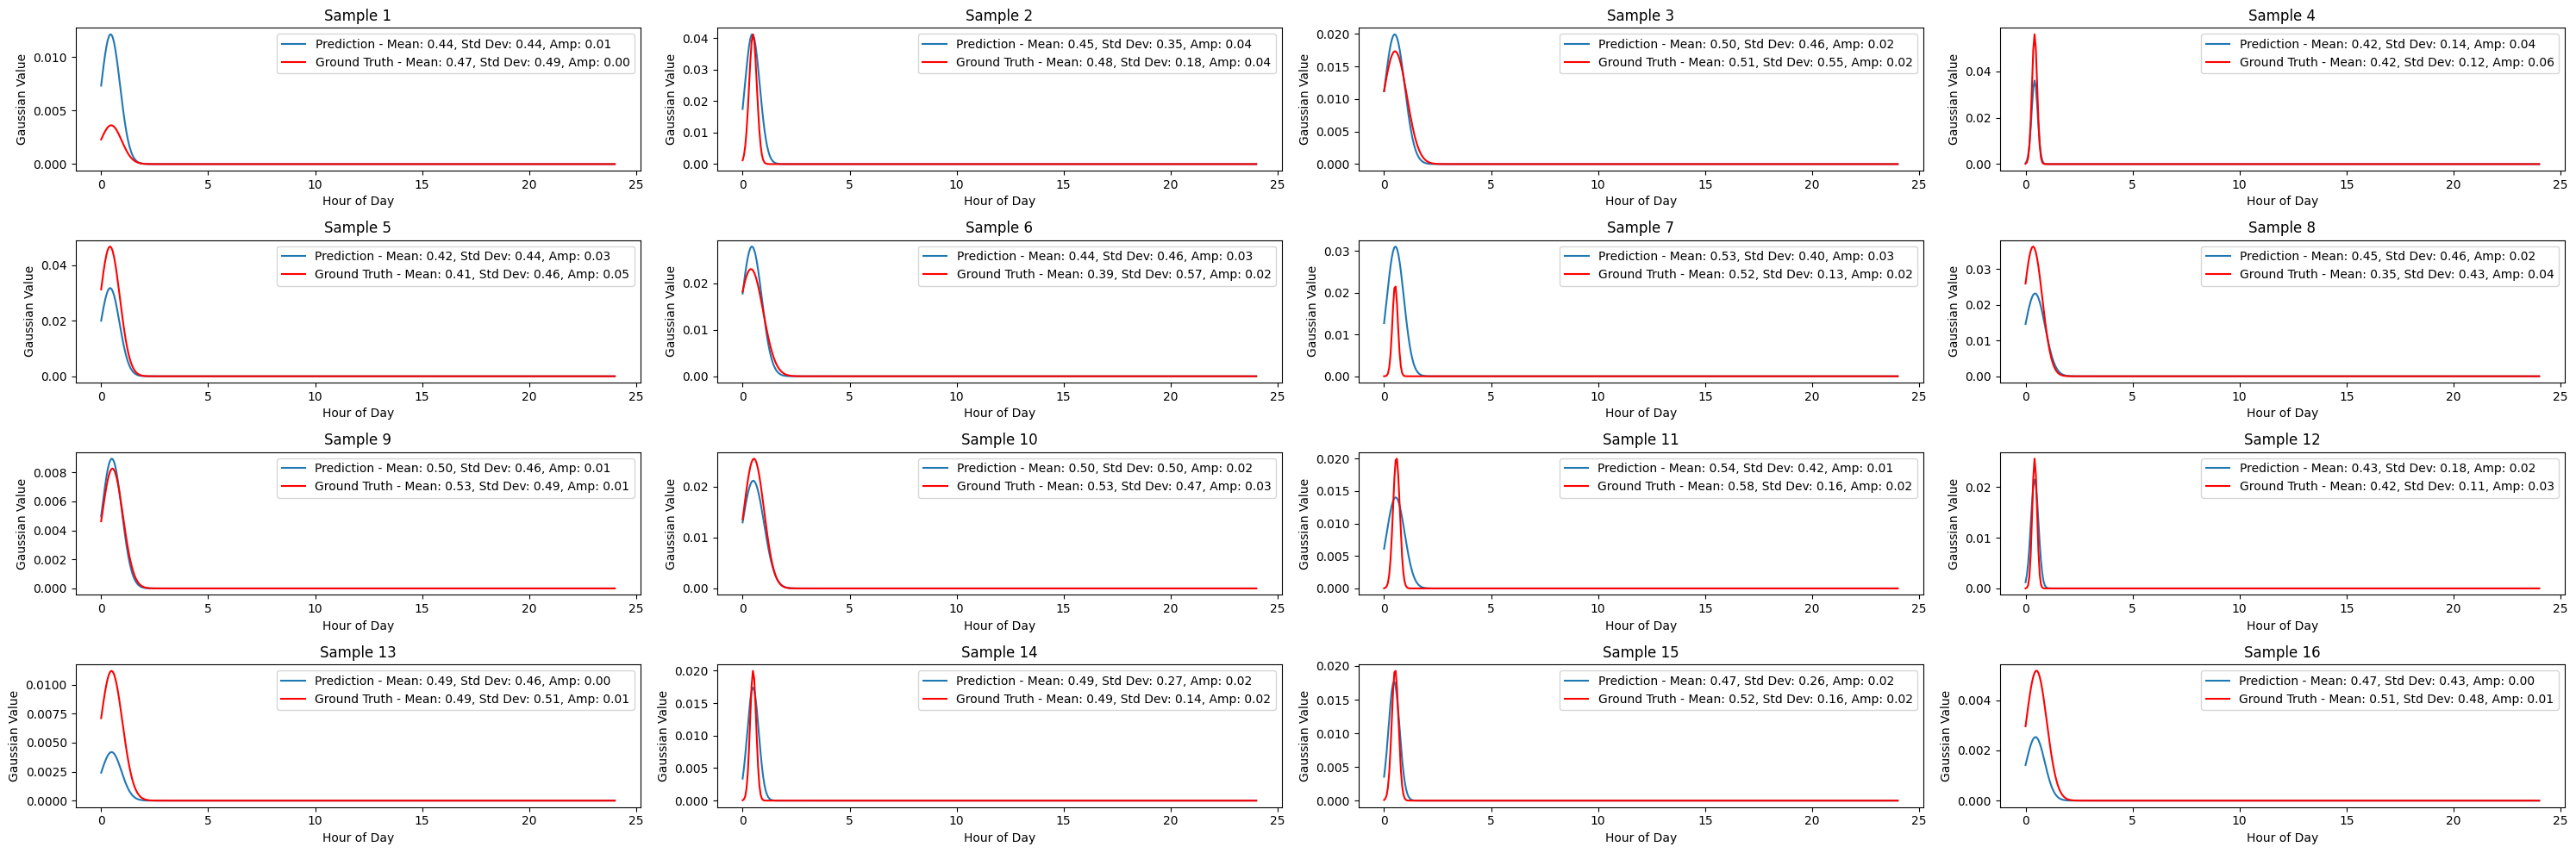

In [224]:
# Load the trained model
trained_model = train_module
trained_model.eval()

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to plot Gaussian curves for multiple samples
def plot_gaussian(samples, x, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_a, pred_b, pred_c = predictions[i] # dataset.denormalize_output(predictions[i])
        gt_a, gt_b, gt_c = ground_truth[i] # dataset.denormalize_output(ground_truth[i])
        
        # Calculate Gaussian curves
        pred_y = gaussian(x, pred_a, pred_b, pred_c)
        gt_y = gaussian(x, gt_a, gt_b, gt_c)
        
        # Plot curves
        ax.plot(x, pred_y, label=f'Prediction - Mean: {pred_b:.2f}, Std Dev: {pred_c:.2f}, Amp: {pred_a:.2f}')
        ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
        ax.set_title(f'Sample {i+1}')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Gaussian Value')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Prepare x-axis for the plot (hours of the day)
x_values = np.linspace(0, 24, 400)

# Number of samples to plot and subplots configuration
num_samples = 16 
rows = 4
cols = 4  

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_synthetic_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = trained_model(samples_dynamic, samples_static)

# Reshape predictions and ground truth if necessary and convert to numpy if still in tensor form
predictions = predictions.numpy()
ground_truth = ground_truth.numpy()

# Plot the Gaussian curves for the predicted values and ground truth
plot_gaussian(num_samples, x_values, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)


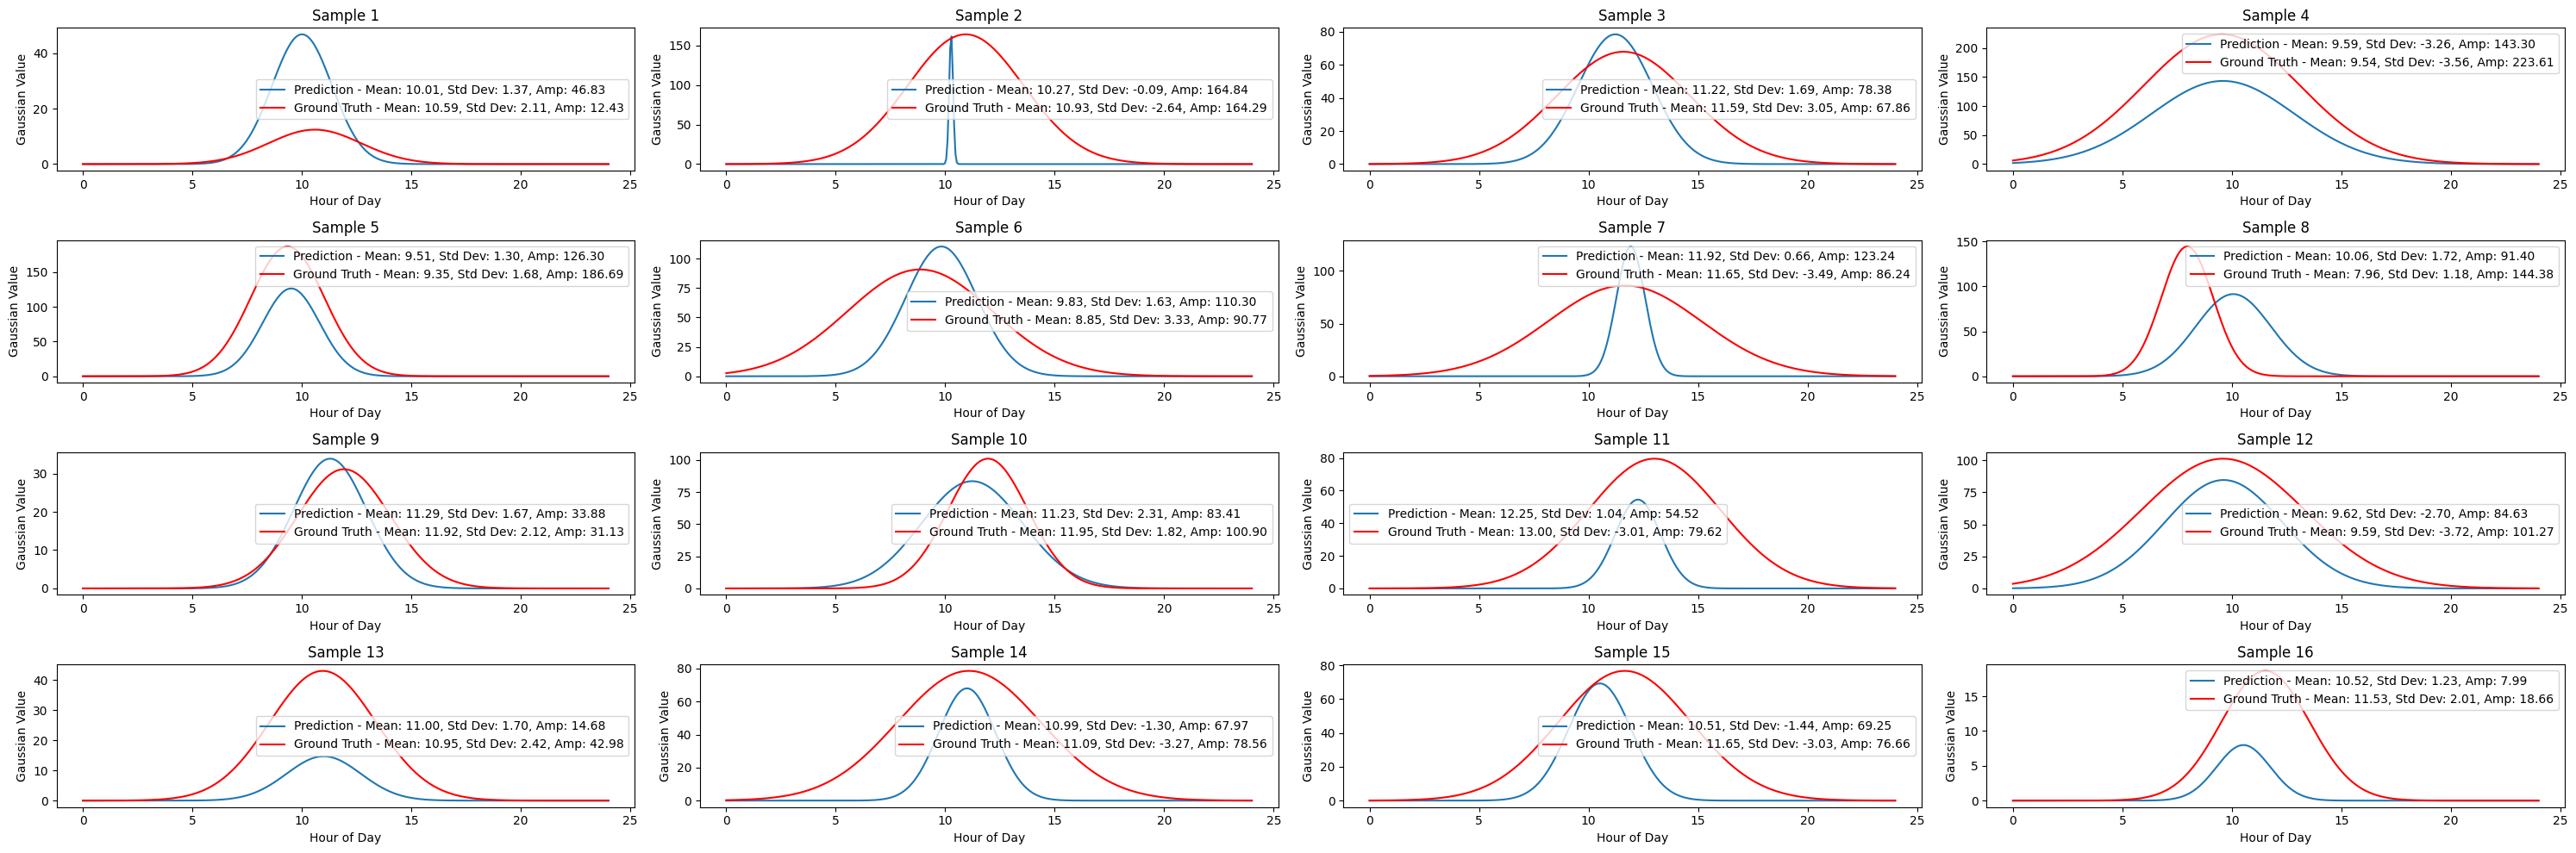

In [225]:
# Load the trained model
trained_model = train_module
trained_model.eval()

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to plot Gaussian curves for multiple samples
def plot_gaussian(samples, x, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_a, pred_b, pred_c = dataset.denormalize_output(predictions[i])
        gt_a, gt_b, gt_c = dataset.denormalize_output(ground_truth[i])
        
        # Calculate Gaussian curves
        pred_y = gaussian(x, pred_a, pred_b, pred_c)
        gt_y = gaussian(x, gt_a, gt_b, gt_c)
        
        # Plot curves
        ax.plot(x, pred_y, label=f'Prediction - Mean: {pred_b:.2f}, Std Dev: {pred_c:.2f}, Amp: {pred_a:.2f}')
        ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
        ax.set_title(f'Sample {i+1}')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Gaussian Value')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Prepare x-axis for the plot (hours of the day)
x_values = np.linspace(0, 24, 400)

# Number of samples to plot and subplots configuration
num_samples = 16 
rows = 4
cols = 4  

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_synthetic_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = trained_model(samples_dynamic, samples_static)

# Reshape predictions and ground truth if necessary and convert to numpy if still in tensor form
predictions = predictions.numpy()
ground_truth = ground_truth.numpy()

# Plot the Gaussian curves for the predicted values and ground truth
plot_gaussian(num_samples, x_values, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)


#### test measurement data

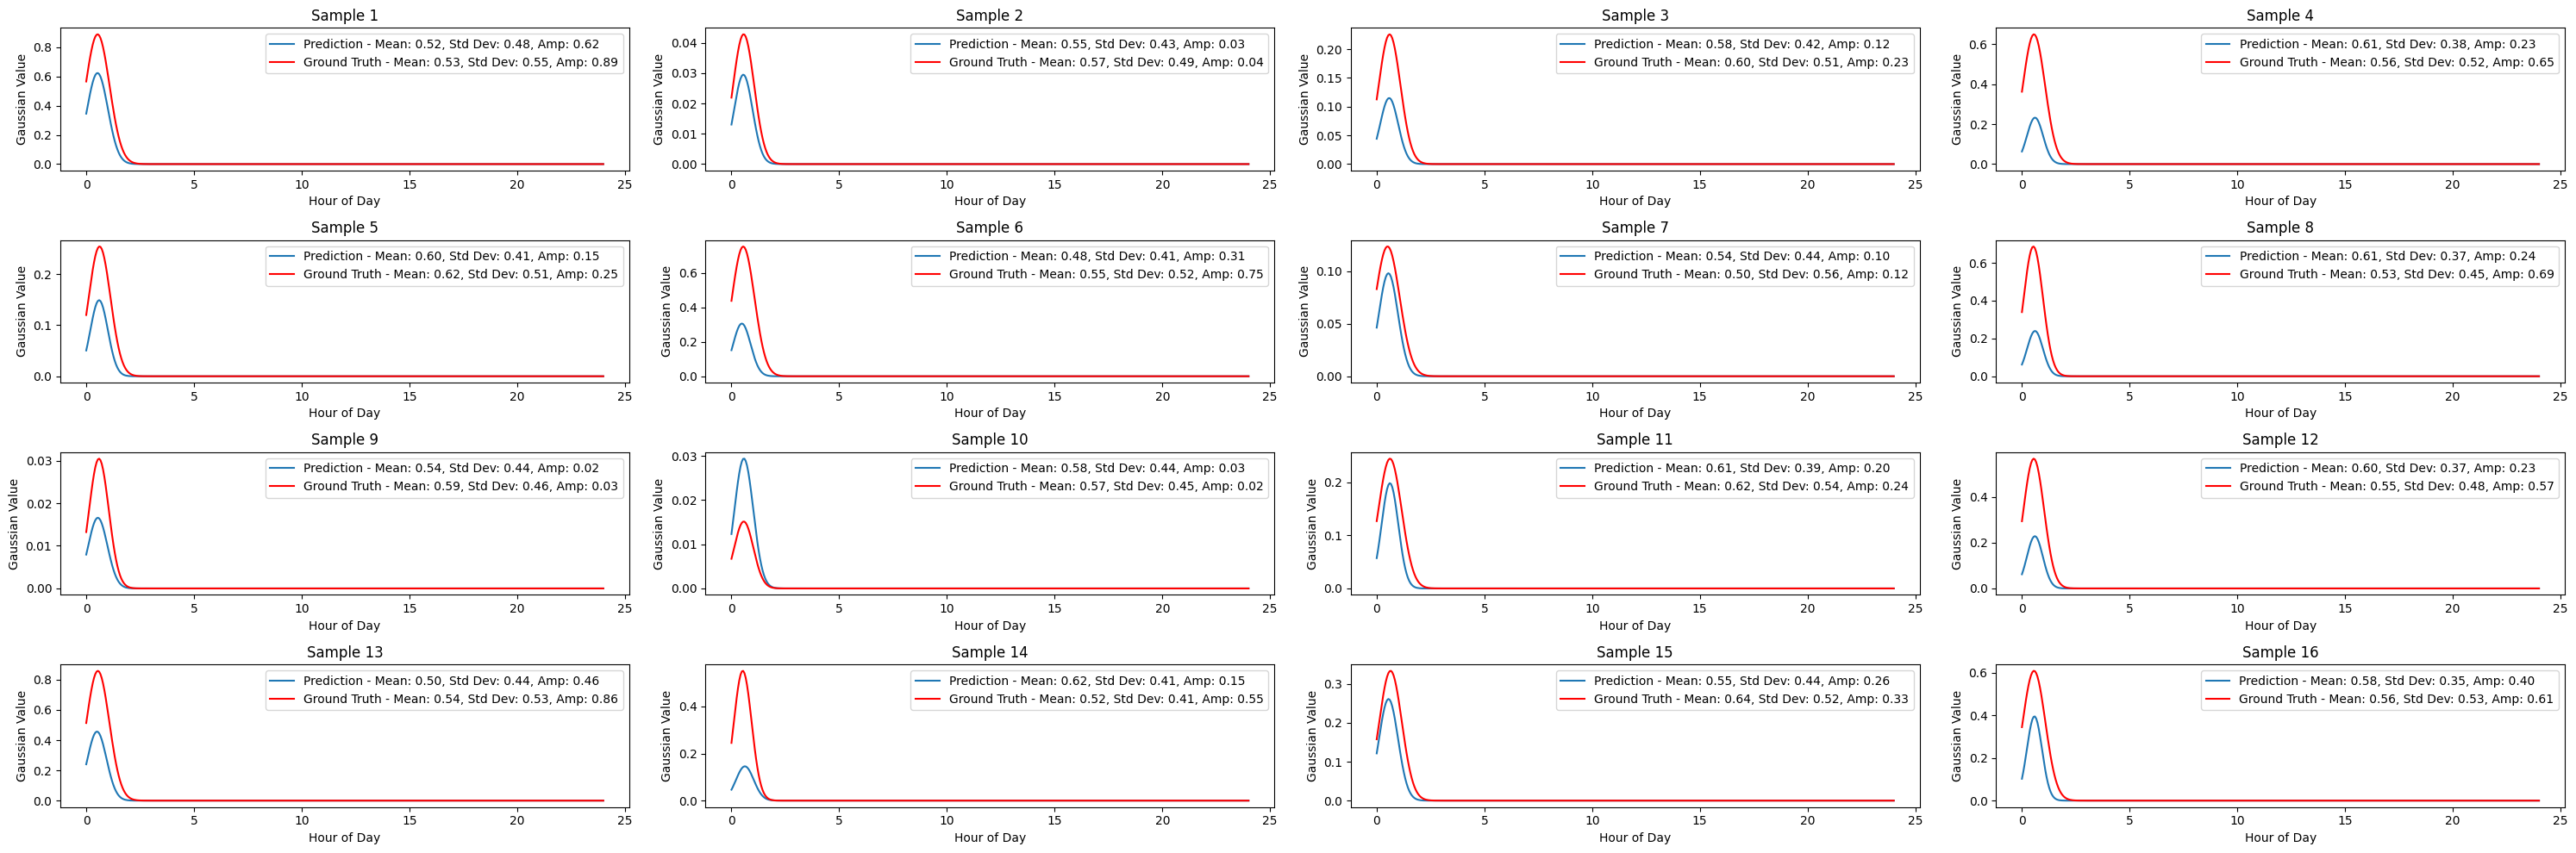

In [226]:
# Load the trained model
trained_model = train_module
trained_model.eval()

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to plot Gaussian curves for multiple samples
def plot_gaussian(samples, x, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_a, pred_b, pred_c = predictions[i] # dataset.denormalize_output(predictions[i])
        gt_a, gt_b, gt_c = ground_truth[i] # dataset.denormalize_output(ground_truth[i])
        
        # Calculate Gaussian curves
        pred_y = gaussian(x, pred_a, pred_b, pred_c)
        gt_y = gaussian(x, gt_a, gt_b, gt_c)
        
        # Plot curves
        ax.plot(x, pred_y, label=f'Prediction - Mean: {pred_b:.2f}, Std Dev: {pred_c:.2f}, Amp: {pred_a:.2f}')
        ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
        ax.set_title(f'Sample {i+1}')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Gaussian Value')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Prepare x-axis for the plot (hours of the day)
x_values = np.linspace(0, 24, 400)

# Number of samples to plot and subplots configuration
num_samples = 16 
rows = 4
cols = 4  

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_measurement_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = trained_model(samples_dynamic, samples_static)

# Reshape predictions and ground truth if necessary and convert to numpy if still in tensor form
predictions = predictions.numpy()
ground_truth = ground_truth.numpy()

# Plot the Gaussian curves for the predicted values and ground truth
plot_gaussian(num_samples, x_values, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)


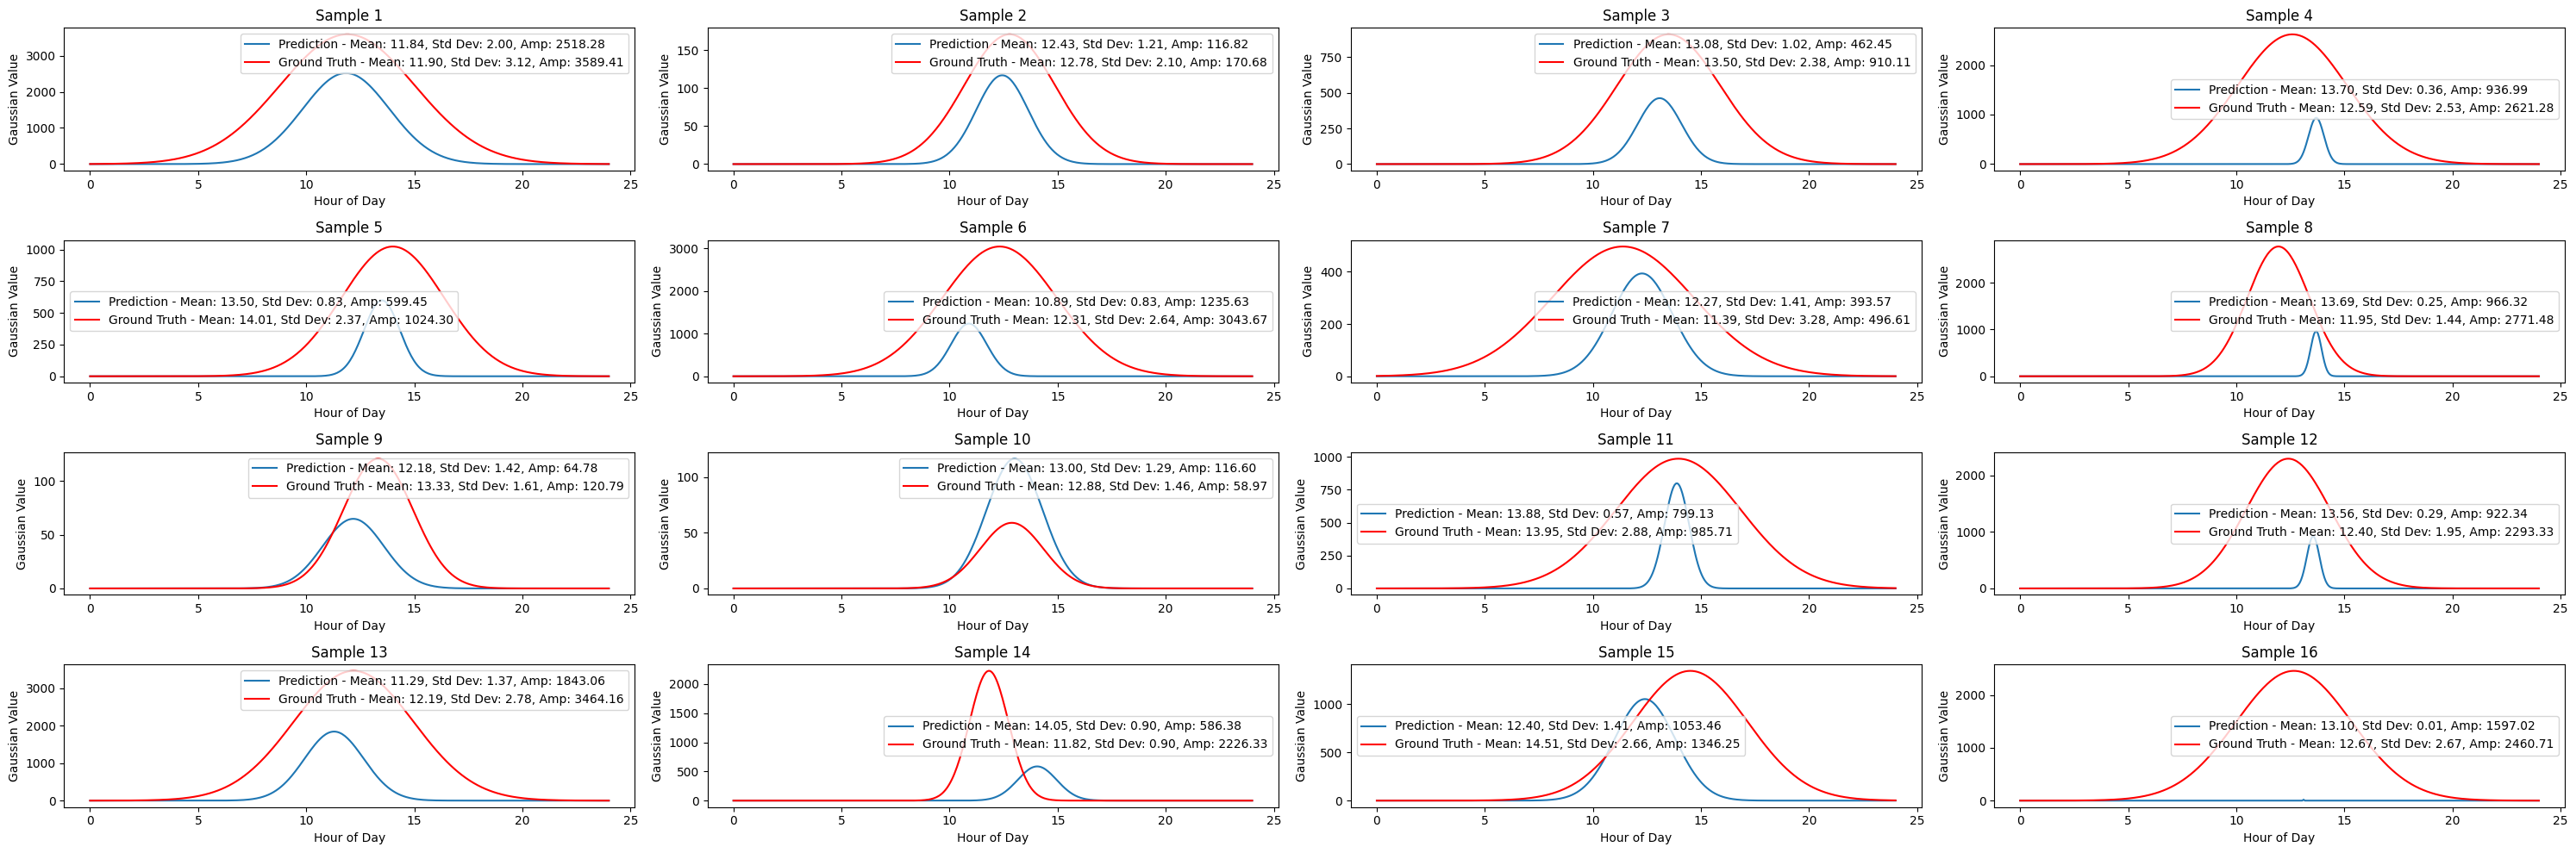

In [227]:
# Load the trained model
trained_model = train_module
trained_model.eval()

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to plot Gaussian curves for multiple samples
def plot_gaussian(samples, x, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_a, pred_b, pred_c = dataset.denormalize_output(predictions[i])
        gt_a, gt_b, gt_c = dataset.denormalize_output(ground_truth[i])
        
        # Calculate Gaussian curves
        pred_y = gaussian(x, pred_a, pred_b, pred_c)
        gt_y = gaussian(x, gt_a, gt_b, gt_c)
        
        # Plot curves
        ax.plot(x, pred_y, label=f'Prediction - Mean: {pred_b:.2f}, Std Dev: {pred_c:.2f}, Amp: {pred_a:.2f}')
        ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
        ax.set_title(f'Sample {i+1}')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Gaussian Value')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Prepare x-axis for the plot (hours of the day)
x_values = np.linspace(0, 24, 400)

# Number of samples to plot and subplots configuration
num_samples = 16 
rows = 4
cols = 4  

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_measurement_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = trained_model(samples_dynamic, samples_static)

# Reshape predictions and ground truth if necessary and convert to numpy if still in tensor form
predictions = predictions.numpy()
ground_truth = ground_truth.numpy()

# Plot the Gaussian curves for the predicted values and ground truth
plot_gaussian(num_samples, x_values, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)


In [38]:
import optuna
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Assuming the create_data_loaders function is defined elsewhere
train_loader, val_loader, test_synthetic_loader, test_measurement_loader = create_data_loaders(
    dataset,
    synthetic_sampling_ratio=1,  # 30% of the synthetic dataset
    measured_split_ratio=0.5,    # 50% of the measured dataset for training
    synthetic_split_ratio=0.7,   # 70% of the synthetic dataset for training
    val_ratio=0.2,               # 10% of the training data for validation
    batch_size=64)  # Initial batch size, this will be overwritten by Optuna

def objective(trial, train_loader, val_loader):
    # Define the hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    hidden_size = trial.suggest_int("hidden_size", 16, 256)
    loss_type = trial.suggest_categorical("loss_type", ['mse', 'l1'])
    lambda_auc = trial.suggest_float("lambda_auc", 0.1, 5.0)
    #BATCHSIZE = trial.suggest_categorical("batchsize", [8, 16, 32, 64, 128])

    # Update batch size for data loaders
    # train_loader.batch_size = BATCHSIZE
    # val_loader.batch_size = BATCHSIZE

    # Instantiate the model with the suggested hyperparameters
    model = TrainEnergyPrediction(
        dynamic_feature_size=5,  
        static_feature_size=3,  
        hidden_size=hidden_size,
        learning_rate=learning_rate,
        loss_type=loss_type,
        lambda_auc=lambda_auc,
    )
    
    logger = CSVLogger("optuna_logs", name="energy_prediction")
    checkpoint_callback = ModelCheckpoint(
        dirpath="models2/",
        filename="best-model-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )
    
    trainer = Trainer(
        logger=logger,
        callbacks=[checkpoint_callback],
        max_epochs=5,
    )
    # Fit the model
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # Use validation loss to determine the best model
    val_loss = trainer.callback_metrics.get("val_loss", float('inf'))

    # Store the best model path in the trial's user attributes
    best_model_path = checkpoint_callback.best_model_path

    if best_model_path:  # Ensure the path is not None or empty
        trial.set_user_attr("best_model_path", best_model_path)
    else:
        raise ValueError("Model checkpoint path is empty!")

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train_loader, val_loader), n_trials=50, timeout=3660)  # Run for 100 trials or 1 hour

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print("Best model saved to:", trial.user_attrs.get('best_model_path', 'Not available'))
    
#print("Best model saved to:", trial.user_attrs['best_model_path'])

[I 2024-06-05 20:48:40,664] A new study created in memory with name: no-name-589a62cf-dede-4c2f-80c5-57dc85640477
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 6.1 K 
1 | loss_fn | L1Loss                | 0     
--------------------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.024     Total estimated model params size (MB)


size of the total dataset: 13454 
size of synthetic data: 12499 = 0.93
size of the measured data: 955 = 0.07

size of the total dataset after subsampling: 13454 
 Size of synthetic data: 12499 = 0.93 
 Size of the measured data: 955 = 0.07 
 ________________________________________________________
 
Training set size (synthetic): 7000 = 0.56 of synthetic data
Training set size (measured): 382 = 0.40 of measured data 

Validation set size (synthetic): 1749 = 0.14 of synthetic data
Validation set size (measured): 95 = 0.10 of measured data 

Test set size (synthetic): 3750 = 0.30 of synthetic data
Test set size (measured): 478 = 0.50 of measured data 



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 13.56028 (best 13.56028), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=13.56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 11.38353 (best 11.38353), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=11.38.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 10.70674 (best 10.70674), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=10.71.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 10.12473 (best 10.12473), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=10.12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 9.92573 (best 9.92573), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=9.93.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 20:49:39,503] Trial 0 finished with value: 9.925731658935547 and parameters: {'learning_rate': 0.008514439445338058, 'hidden_size': 18, 'loss_type': 'l1', 'lambda_auc': 2.7455466672208115}. Best is trial 0 with value: 9.925731658935547.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 10.40260 (best 10.40260), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=10.40.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 9.99595 (best 9.99595), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=10.00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 9.74245 (best 9.74245), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=9.74.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 9.01912 (best 9.01912), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=9.02.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 20:51:04,516] Trial 1 finished with value: 9.063522338867188 and parameters: {'learning_rate': 0.000856867335732306, 'hidden_size': 240, 'loss_type': 'l1', 'lambda_auc': 0.10479760120977916}. Best is trial 1 with value: 9.063522338867188.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 357 K 
1 | loss_fn | MSELoss               | 0     
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 3.29615 (best 3.29615), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=3.30.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 2.71157 (best 2.71157), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=2.71.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 2.44681 (best 2.44681), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=2.45.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 2.29812 (best 2.29812), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=2.30.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 2.23881 (best 2.23881), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=2.24.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 20:52:15,087] Trial 2 finished with value: 2.238811731338501 and parameters: {'learning_rate': 9.969253380697165e-05, 'hidden_size': 148, 'loss_type': 'mse', 'lambda_auc': 3.683228259897709}. Best is trial 2 with value: 2.238811731338501.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 32.51721 (best 32.51721), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=32.52.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 3.21370 (best 3.21370), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=3.21.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 2.94229 (best 2.94229), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=2.94.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 2.70026 (best 2.70026), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=2.70.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 2.53090 (best 2.53090), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=2.53.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 20:53:21,760] Trial 3 finished with value: 2.5309011936187744 and parameters: {'learning_rate': 4.8746565603609355e-05, 'hidden_size': 95, 'loss_type': 'mse', 'lambda_auc': 2.659200340835283}. Best is trial 2 with value: 2.238811731338501.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 42.84304 (best 42.84304), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=42.84.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 20:54:25,269] Trial 4 finished with value: 42.84304428100586 and parameters: {'learning_rate': 0.06920763340225451, 'hidden_size': 64, 'loss_type': 'l1', 'lambda_auc': 1.1646277125321967}. Best is trial 2 with value: 2.238811731338501.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 311 K 
1 | loss_fn | MSELoss               | 0     
---------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.25841 (best 2.25841), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.26.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 2.08074 (best 2.08074), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=2.08.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 2.03530 (best 2.03530), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=2.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.89270 (best 1.89270), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.89.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.88652 (best 1.88652), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.89.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 20:55:34,719] Trial 5 finished with value: 1.886516809463501 and parameters: {'learning_rate': 0.0006953372994997192, 'hidden_size': 138, 'loss_type': 'mse', 'lambda_auc': 2.438150165308021}. Best is trial 5 with value: 1.886516809463501.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 13.08552 (best 13.08552), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=13.09.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 11.06058 (best 11.06058), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=11.06.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 10.57311 (best 10.57311), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=10.57.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 9.81287 (best 9.81287), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=9.81.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 9.54798 (best 9.54798), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=9.55.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 20:56:35,796] Trial 6 finished with value: 9.547975540161133 and parameters: {'learning_rate': 0.0006048934289056255, 'hidden_size': 33, 'loss_type': 'l1', 'lambda_auc': 0.13703547380146947}. Best is trial 5 with value: 1.886516809463501.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 14.88189 (best 14.88189), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=14.88.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 12.50930 (best 12.50930), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=12.51.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 11.31828 (best 11.31828), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=11.32.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 10.63867 (best 10.63867), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=10.64.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 10.62719 (best 10.62719), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=10.63.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 20:57:29,987] Trial 7 finished with value: 10.627191543579102 and parameters: {'learning_rate': 0.007390066022543348, 'hidden_size': 18, 'loss_type': 'l1', 'lambda_auc': 4.758368155989647}. Best is trial 5 with value: 1.886516809463501.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 1.79695 (best 1.79695), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=1.80.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.74176 (best 1.74176), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.74.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.70300 (best 1.70300), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.70.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.70229 (best 1.70229), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.70.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 20:58:30,766] Trial 8 finished with value: 1.790992021560669 and parameters: {'learning_rate': 0.008945155108056076, 'hidden_size': 34, 'loss_type': 'mse', 'lambda_auc': 0.6608352904498515}. Best is trial 8 with value: 1.790992021560669.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 315 K 
1 | loss_fn | MSELoss               | 0     
-------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 46.30851 (best 46.30851), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=46.31.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 4.62654 (best 4.62654), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=4.63.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 2.89882 (best 2.89882), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=2.90.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 2.75857 (best 2.75857), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=2.76.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 2.65041 (best 2.65041), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=2.65.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 20:59:40,142] Trial 9 finished with value: 2.6504127979278564 and parameters: {'learning_rate': 2.0295838020842967e-05, 'hidden_size': 139, 'loss_type': 'mse', 'lambda_auc': 1.671726738106673}. Best is trial 8 with value: 1.790992021560669.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 16.78989 (best 16.78989), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=16.79.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:00:57,627] Trial 10 finished with value: 16.78989028930664 and parameters: {'learning_rate': 0.0753464078001725, 'hidden_size': 206, 'loss_type': 'mse', 'lambda_auc': 1.1842217486324154}. Best is trial 8 with value: 1.790992021560669.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 168 K 
1 | loss_fn | MSELoss               | 0     
-------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.79764 (best 2.79764), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.80.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 2.13615 (best 2.13615), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=2.14.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.96275 (best 1.96275), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.96-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:02:06,963] Trial 11 finished with value: 2.153977155685425 and parameters: {'learning_rate': 0.00538069258368452, 'hidden_size': 101, 'loss_type': 'mse', 'lambda_auc': 3.6751826040232993}. Best is trial 8 with value: 1.790992021560669.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 492 K 
1 | loss_fn | MSELoss               | 0     
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.20489 (best 2.20489), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.20.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 2.04249 (best 2.04249), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=2.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.97849 (best 1.97849), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.98.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.89431 (best 1.89431), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.89.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.83385 (best 1.83385), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.83-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:03:21,648] Trial 12 finished with value: 1.833851933479309 and parameters: {'learning_rate': 0.0002898930894293654, 'hidden_size': 174, 'loss_type': 'mse', 'lambda_auc': 1.860699398236467}. Best is trial 8 with value: 1.790992021560669.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.34817 (best 2.34817), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.35.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.97835 (best 1.97835), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.98.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.90626 (best 1.90626), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.91.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.84652 (best 1.84652), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.85.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.80555 (best 1.80555), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.81-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:04:37,367] Trial 13 finished with value: 1.8055540323257446 and parameters: {'learning_rate': 0.00018450345770419603, 'hidden_size': 181, 'loss_type': 'mse', 'lambda_auc': 0.8867354728911432}. Best is trial 8 with value: 1.790992021560669.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 1.99067 (best 1.99067), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=1.99.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.78982 (best 1.78982), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.79.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.77134 (best 1.77134), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.77-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.62997 (best 1.62997), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.63.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:05:53,212] Trial 14 finished with value: 1.6299705505371094 and parameters: {'learning_rate': 0.0029690687592228973, 'hidden_size': 189, 'loss_type': 'mse', 'lambda_auc': 0.7793673218981356}. Best is trial 14 with value: 1.6299705505371094.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Typ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.13705 (best 2.13705), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.14.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.99096 (best 1.99096), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.99.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.89080 (best 1.89080), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.89.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.71181 (best 1.71181), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.71.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:07:15,358] Trial 15 finished with value: 1.7362310886383057 and parameters: {'learning_rate': 0.002941093379476708, 'hidden_size': 240, 'loss_type': 'mse', 'lambda_auc': 0.5896164537263275}. Best is trial 14 with value: 1.6299705505371094.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 1.0 M 
1 | loss_fn | MSELoss               | 0     
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 3.05639 (best 3.05639), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=3.06.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 2.92690 (best 2.92690), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=2.93.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 2.06057 (best 2.06057), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=2.06.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 2.00891 (best 2.00891), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=2.01.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.79665 (best 1.79665), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.80-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:08:39,489] Trial 16 finished with value: 1.796648621559143 and parameters: {'learning_rate': 0.003318064903293966, 'hidden_size': 251, 'loss_type': 'mse', 'lambda_auc': 1.7761517781345026}. Best is trial 14 with value: 1.6299705505371094.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Ty

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 1.94735 (best 1.94735), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=1.95.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.76931 (best 1.76931), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.77.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.70266 (best 1.70266), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.70.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:09:59,102] Trial 17 finished with value: 1.7026572227478027 and parameters: {'learning_rate': 0.0021965016121622645, 'hidden_size': 225, 'loss_type': 'mse', 'lambda_auc': 0.6031170174447423}. Best is trial 14 with value: 1.6299705505371094.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Typ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.12802 (best 2.12802), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.13.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 2.10734 (best 2.10734), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=2.11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 2.00714 (best 2.00714), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=2.01.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.95783 (best 1.95783), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.96-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.94753 (best 1.94753), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.95.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:11:17,401] Trial 18 finished with value: 1.9475284814834595 and parameters: {'learning_rate': 0.0017471120453049346, 'hidden_size': 211, 'loss_type': 'mse', 'lambda_auc': 1.3765326065958534}. Best is trial 14 with value: 1.6299705505371094.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Typ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 17.16258 (best 17.16258), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=17.16.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:12:36,140] Trial 19 finished with value: 17.162580490112305 and parameters: {'learning_rate': 0.02622234554213205, 'hidden_size': 216, 'loss_type': 'mse', 'lambda_auc': 2.191986959445506}. Best is trial 14 with value: 1.6299705505371094.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 538 K 
1 | loss_fn | MSELoss               | 0     
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 17.51884 (best 17.51884), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=17.52.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:13:51,266] Trial 20 finished with value: 17.518835067749023 and parameters: {'learning_rate': 0.02532560899922046, 'hidden_size': 182, 'loss_type': 'mse', 'lambda_auc': 3.155310725962269}. Best is trial 14 with value: 1.6299705505371094.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 864 K 
1 | loss_fn | MSELoss               | 0     
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 1.94986 (best 1.94986), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=1.95.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.76817 (best 1.76817), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.77.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.71722 (best 1.71722), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.72.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.62992 (best 1.62992), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.63-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:15:12,852] Trial 21 finished with value: 1.6299175024032593 and parameters: {'learning_rate': 0.0016182571374091627, 'hidden_size': 231, 'loss_type': 'mse', 'lambda_auc': 0.5084965434155214}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 1.95616 (best 1.95616), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=1.96.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.79082 (best 1.79082), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.79.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.73167 (best 1.73167), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.73.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:16:34,026] Trial 22 finished with value: 1.7316699028015137 and parameters: {'learning_rate': 0.0016999780291533104, 'hidden_size': 223, 'loss_type': 'mse', 'lambda_auc': 0.44204693003261974}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Ty

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.00922 (best 2.00922), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.01.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.89808 (best 1.89808), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.90.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.77468 (best 1.77468), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.77.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.77094 (best 1.77094), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.77.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:17:49,849] Trial 23 finished with value: 1.7709431648254395 and parameters: {'learning_rate': 0.0003729851552471812, 'hidden_size': 188, 'loss_type': 'mse', 'lambda_auc': 0.945454098932142}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 1.83834 (best 1.83834), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=1.84.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.78476 (best 1.78476), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.78.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.74323 (best 1.74323), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.74.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.68140 (best 1.68140), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.68.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:19:03,239] Trial 24 finished with value: 1.7703279256820679 and parameters: {'learning_rate': 0.001523135989275165, 'hidden_size': 157, 'loss_type': 'mse', 'lambda_auc': 0.38430788746652766}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 850 K 
1 | loss_fn | MSELoss               | 0     
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 16.87901 (best 16.87901), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=16.88.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:20:24,295] Trial 25 finished with value: 16.879005432128906 and parameters: {'learning_rate': 0.013239691813488583, 'hidden_size': 229, 'loss_type': 'mse', 'lambda_auc': 1.4251980022228359}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 643 K 
1 | loss_fn | L1Loss                | 0     
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 11.69254 (best 11.69254), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=11.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 10.97303 (best 10.97303), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=10.97.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 9.07440 (best 9.07440), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=9.07.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:21:41,904] Trial 26 finished with value: 9.301339149475098 and parameters: {'learning_rate': 0.0023180065309142523, 'hidden_size': 199, 'loss_type': 'l1', 'lambda_auc': 0.8905780757060515}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 1.0 M 
1 | loss_fn | MSELoss               | 0     
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 32.96749 (best 32.96749), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=32.97.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:23:05,830] Trial 27 finished with value: 32.96749496459961 and parameters: {'learning_rate': 0.019934352241365638, 'hidden_size': 252, 'loss_type': 'mse', 'lambda_auc': 4.925681032240525}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 427 K 
1 | loss_fn | MSELoss               | 0     
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 1.91729 (best 1.91729), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=1.92.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.80897 (best 1.80897), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.81.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.77485 (best 1.77485), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.77.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.73068 (best 1.73068), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.73.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.72632 (best 1.72632), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.73-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:24:19,224] Trial 28 finished with value: 1.726318120956421 and parameters: {'learning_rate': 0.001097645136707802, 'hidden_size': 162, 'loss_type': 'mse', 'lambda_auc': 0.6575433759617499}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Ty

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 10.10719 (best 10.10719), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=10.11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 9.92333 (best 9.92333), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=9.92.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 9.48731 (best 9.48731), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=9.49.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 9.04799 (best 9.04799), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=9.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 8.62378 (best 8.62378), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=8.62.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:25:27,860] Trial 29 finished with value: 8.623781204223633 and parameters: {'learning_rate': 0.0036514558984506325, 'hidden_size': 113, 'loss_type': 'l1', 'lambda_auc': 0.24442124603411525}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.21084 (best 2.21084), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.21.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 2.03594 (best 2.03594), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=2.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.95706 (best 1.95706), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.96.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.84126 (best 1.84126), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.84.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:26:45,281] Trial 30 finished with value: 1.9400451183319092 and parameters: {'learning_rate': 0.00042099841799723986, 'hidden_size': 199, 'loss_type': 'mse', 'lambda_auc': 2.105433839819522}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 438 K 
1 | loss_fn | MSELoss               | 0     
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 1.99192 (best 1.99192), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=1.99.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.93227 (best 1.93227), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.93.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.72552 (best 1.72552), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.73-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.72529 (best 1.72529), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.73.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:27:58,847] Trial 31 finished with value: 1.7477885484695435 and parameters: {'learning_rate': 0.001277137704804027, 'hidden_size': 164, 'loss_type': 'mse', 'lambda_auc': 0.7017686284383283}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 842 K 
1 | loss_fn | MSELoss               | 0     
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.00398 (best 2.00398), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.87451 (best 1.87451), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.87.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:29:19,392] Trial 32 finished with value: 1.87571120262146 and parameters: {'learning_rate': 0.004301789913285557, 'hidden_size': 228, 'loss_type': 'mse', 'lambda_auc': 1.1288453779384549}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 232 K 
1 | loss_fn | MSELoss               | 0     
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 1.85009 (best 1.85009), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=1.85.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.70844 (best 1.70844), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.71.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:30:28,481] Trial 33 finished with value: 1.721235752105713 and parameters: {'learning_rate': 0.0009152353062241133, 'hidden_size': 119, 'loss_type': 'mse', 'lambda_auc': 0.40465227103606344}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 202 K 
1 | loss_fn | MSELoss               | 0     
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.35466 (best 2.35466), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.35.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 2.10567 (best 2.10567), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=2.11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.94451 (best 1.94451), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.94-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.88031 (best 1.88031), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.88-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.84430 (best 1.84430), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.84-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:31:36,950] Trial 34 finished with value: 1.8442965745925903 and parameters: {'learning_rate': 0.00010238104172825674, 'hidden_size': 111, 'loss_type': 'mse', 'lambda_auc': 0.22365876652995742}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 11.03543 (best 11.03543), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=11.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 9.90488 (best 9.90488), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=9.90.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 9.57559 (best 9.57559), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=9.58.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 9.39826 (best 9.39826), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=9.40.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 9.32681 (best 9.32681), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=9.33.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:32:41,951] Trial 35 finished with value: 9.326811790466309 and parameters: {'learning_rate': 0.0007609390654343191, 'hidden_size': 72, 'loss_type': 'l1', 'lambda_auc': 0.1082990777247797}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.61137 (best 2.61137), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.61.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 2.17517 (best 2.17517), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=2.18.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 2.03364 (best 2.03364), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=2.03.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.98046 (best 1.98046), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.98-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.93919 (best 1.93919), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.94.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:33:51,051] Trial 36 finished with value: 1.9391899108886719 and parameters: {'learning_rate': 0.0001453088410522785, 'hidden_size': 128, 'loss_type': 'mse', 'lambda_auc': 1.5388457309945203}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Typ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.11454 (best 2.11454), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.93825 (best 1.93825), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.94.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.82017 (best 1.82017), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.82.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.73110 (best 1.73110), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.73-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:35:12,834] Trial 37 finished with value: 1.7311034202575684 and parameters: {'learning_rate': 0.0008506473521869129, 'hidden_size': 240, 'loss_type': 'mse', 'lambda_auc': 1.0550489983381746}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 11.32806 (best 11.32806), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=11.33.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 9.55086 (best 9.55086), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=9.55.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 9.09961 (best 9.09961), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=9.10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 9.06176 (best 9.06176), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=9.06.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:36:18,927] Trial 38 finished with value: 9.061761856079102 and parameters: {'learning_rate': 0.006498447240057694, 'hidden_size': 81, 'loss_type': 'l1', 'lambda_auc': 0.4166131954787837}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 17.55905 (best 17.55905), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=17.56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:37:33,520] Trial 39 finished with value: 17.559051513671875 and parameters: {'learning_rate': 0.010908746981006513, 'hidden_size': 193, 'loss_type': 'mse', 'lambda_auc': 3.264062498426129}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 367 K 
1 | loss_fn | MSELoss               | 0     
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 19.12254 (best 19.12254), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=19.12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 2.62397 (best 2.62397), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=2.62.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 2.53024 (best 2.53024), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=2.53.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 2.41019 (best 2.41019), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=2.41.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 2.28964 (best 2.28964), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=2.29.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:38:43,832] Trial 40 finished with value: 2.2896366119384766 and parameters: {'learning_rate': 3.0089397522475847e-05, 'hidden_size': 150, 'loss_type': 'mse', 'lambda_auc': 1.272049658264847}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Typ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.18195 (best 2.18195), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.18.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.83904 (best 1.83904), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.84.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.72709 (best 1.72709), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.73-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.71406 (best 1.71406), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.71-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:39:56,290] Trial 41 finished with value: 1.7528866529464722 and parameters: {'learning_rate': 0.0010933204998419372, 'hidden_size': 171, 'loss_type': 'mse', 'lambda_auc': 0.6780605485229355}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 298 K 
1 | loss_fn | MSELoss               | 0     
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 1.96743 (best 1.96743), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=1.97.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.83867 (best 1.83867), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.84.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.75401 (best 1.75401), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.75.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.74661 (best 1.74661), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.75.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.72692 (best 1.72692), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.73-v3.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:41:04,602] Trial 42 finished with value: 1.7269160747528076 and parameters: {'learning_rate': 0.0005125072245122574, 'hidden_size': 135, 'loss_type': 'mse', 'lambda_auc': 0.5698809883117703}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 1.91825 (best 1.91825), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=1.92.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.81191 (best 1.81191), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.81.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.77383 (best 1.77383), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.77-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.73528 (best 1.73528), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.74.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:42:25,347] Trial 43 finished with value: 1.7352771759033203 and parameters: {'learning_rate': 0.0009334041878309629, 'hidden_size': 238, 'loss_type': 'mse', 'lambda_auc': 0.8293062107404825}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Typ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 1.78722 (best 1.78722), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=1.79.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.74395 (best 1.74395), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.74.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.68132 (best 1.68132), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.68-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:43:42,832] Trial 44 finished with value: 1.7097759246826172 and parameters: {'learning_rate': 0.0022959904977124922, 'hidden_size': 215, 'loss_type': 'mse', 'lambda_auc': 0.43284835244486203}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 763 K 
1 | loss_fn | MSELoss               | 0     
------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 2.01656 (best 2.01656), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=2.02.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 1.76147 (best 1.76147), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=1.76.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.73835 (best 1.73835), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.74.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.69079 (best 1.69079), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.69-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:45:00,443] Trial 45 finished with value: 1.6907933950424194 and parameters: {'learning_rate': 0.002531330344996087, 'hidden_size': 217, 'loss_type': 'mse', 'lambda_auc': 0.3449676130177276}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 10.17052 (best 10.17052), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=10.17.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' reached 9.88287 (best 9.88287), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=9.88.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 9.50706 (best 9.50706), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=9.51.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 8.87121 (best 8.87121), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=8.87.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:46:16,726] Trial 46 finished with value: 8.940608024597168 and parameters: {'learning_rate': 0.0023421799573032655, 'hidden_size': 211, 'loss_type': 'l1', 'lambda_auc': 0.1491602586689137}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 799 K 
1 | loss_fn | MSELoss               | 0     
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 31.49872 (best 31.49872), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=31.50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:47:35,171] Trial 47 finished with value: 31.498720169067383 and parameters: {'learning_rate': 0.005877656844283332, 'hidden_size': 222, 'loss_type': 'mse', 'lambda_auc': 0.954082847108001}. Best is trial 21 with value: 1.6299175024032593.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 675 K 
1 | loss_fn | MSELoss               | 0     
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 1.80445 (best 1.80445), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=1.80.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' reached 1.75851 (best 1.75851), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=1.76.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' reached 1.71863 (best 1.71863), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=1.72-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' reached 1.62694 (best 1.62694), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.63-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:48:50,528] Trial 48 finished with value: 1.6269432306289673 and parameters: {'learning_rate': 0.0023967513326299122, 'hidden_size': 204, 'loss_type': 'mse', 'lambda_auc': 0.39062097885403585}. Best is trial 48 with value: 1.6269432306289673.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 116: 'val_loss' reached 31.60311 (best 31.60311), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=31.60.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 348: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-05 21:50:05,536] Trial 49 finished with value: 31.603107452392578 and parameters: {'learning_rate': 0.049283008151698456, 'hidden_size': 199, 'loss_type': 'mse', 'lambda_auc': 1.2363383797729919}. Best is trial 48 with value: 1.6269432306289673.


Best trial:
  Value:  1.6269432306289673
  Params: 
    learning_rate: 0.0023967513326299122
    hidden_size: 204
    loss_type: mse
    lambda_auc: 0.39062097885403585
Best model saved to: C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2\best-model-epoch=04-val_loss=1.63-v2.ckpt


In [39]:
import torch
from pytorch_lightning import Trainer

# Assuming test_synthetic_loader and test_measurement_loader are already created

def load_model(checkpoint_path, trial):
    # Extract hyperparameters from the trial
    learning_rate = trial.params['learning_rate']
    hidden_size = trial.params['hidden_size']
    loss_type = trial.params['loss_type']
    lambda_auc = trial.params['lambda_auc']

    # Instantiate the model with the trial's hyperparameters
    model = TrainEnergyPrediction(
        dynamic_feature_size=5,  
        static_feature_size=3,  
        hidden_size=hidden_size,
        learning_rate=learning_rate,
        loss_type=loss_type,
        lambda_auc=lambda_auc,
    )
    
    # Load the model's weights from the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

def evaluate_model(model, test_loader):
    trainer = Trainer(logger=False)
    results = trainer.test(model, dataloaders=test_loader)
    return results

# Retrieve the best trial
best_trial = study.best_trial
print(best_trial)

# Print all user attributes to debug
print("User attributes of the best trial:", best_trial.user_attrs)

# Check if 'best_model_path' is present
if 'best_model_path' in best_trial.user_attrs:
    checkpoint_path = best_trial.user_attrs['best_model_path']

    # Load the best model
    model = load_model(checkpoint_path, best_trial)

    print(f"Evaluating best model from trial {best_trial.number}")

    # Evaluate on both synthetic and measurement test loaders
    model_results = evaluate_model(model, [test_synthetic_loader,test_measurement_loader])
    print("Results for the best model:")
    print("Synthetic Test Set:", model_results)
    
else:
    print("Best model path not found in the best trial's user attributes.")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FrozenTrial(number=48, state=1, values=[1.6269432306289673], datetime_start=datetime.datetime(2024, 6, 5, 21, 47, 35, 172528), datetime_complete=datetime.datetime(2024, 6, 5, 21, 48, 50, 528998), params={'learning_rate': 0.0023967513326299122, 'hidden_size': 204, 'loss_type': 'mse', 'lambda_auc': 0.39062097885403585}, user_attrs={'best_model_path': 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=1.63-v2.ckpt'}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'hidden_size': IntDistribution(high=256, log=False, low=16, step=1), 'loss_type': CategoricalDistribution(choices=('mse', 'l1')), 'lambda_auc': FloatDistribution(high=5.0, log=False, low=0.1, step=None)}, trial_id=48, value=None)
User attributes of the best trial: {'best_model_path': 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary t

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         auc_loss          │   0.001152191893197596    │    1.6722931861877441     │
│        param_loss         │    1.5576751232147217     │    1.7899353504180908     │
│        total_loss         │    1.5581251382827759     │    2.4431684017181396     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

Results for the best model:
Synthetic Test Set: [{'total_loss/dataloader_idx_0': 1.5581251382827759, 'param_loss/dataloader_idx_0': 1.5576751232147217, 'auc_loss/dataloader_idx_0': 0.001152191893197596}, {'total_loss/dataloader_idx_1': 2.4431684017181396, 'param_loss/dataloader_idx_1': 1.7899353504180908, 'auc_loss/dataloader_idx_1': 1.6722931861877441}]


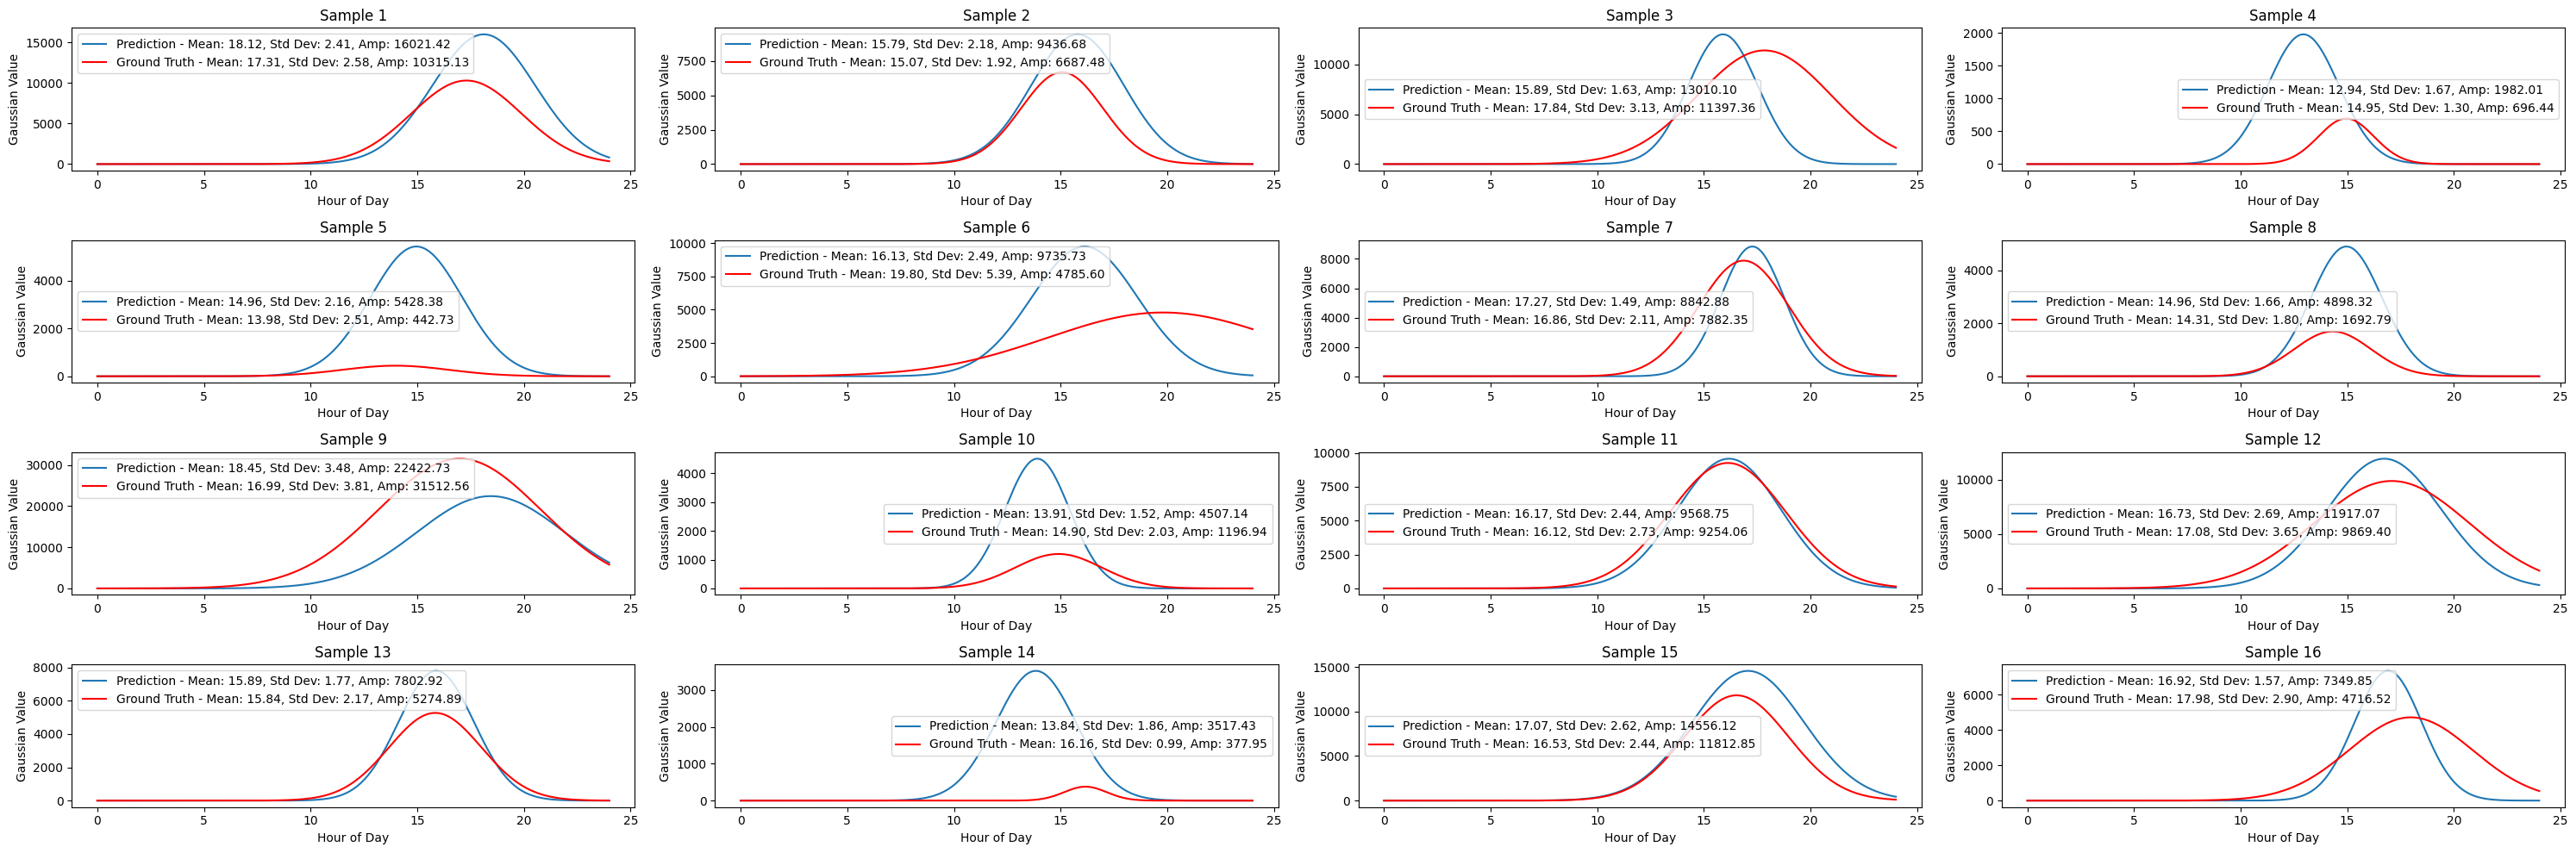

In [42]:
# inference
import numpy as np
import matplotlib.pyplot as plt
import torch
from pytorch_lightning import Trainer

# Ensure that TrainEnergyPrediction and EnergyPredictionModel are defined
# Your model class definition here

def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

def plot_gaussian(samples, x, predictions, ground_truth, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_a, pred_b, pred_c = dataset.denormalize_output(predictions[i])
        gt_a, gt_b, gt_c = dataset.denormalize_output(ground_truth[i])
        
        # Calculate Gaussian curves
        pred_y = gaussian(x, pred_a, pred_b, pred_c)
        gt_y = gaussian(x, gt_a, gt_b, gt_c)
        
        # Plot curves
        ax.plot(x, pred_y, label=f'Prediction - Mean: {pred_b:.2f}, Std Dev: {pred_c:.2f}, Amp: {pred_a:.2f}')
        ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
        ax.set_title(f'Sample {i+1}')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Gaussian Value')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def load_model(checkpoint_path):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    
    # Extract hyperparameters from the checkpoint
    hyperparameters = checkpoint['hyper_parameters']
    dynamic_feature_size = hyperparameters['dynamic_feature_size']
    static_feature_size = hyperparameters['static_feature_size']
    hidden_size = hyperparameters['hidden_size']
    learning_rate = hyperparameters['learning_rate']
    loss_type = hyperparameters['loss_type']
    lambda_auc = hyperparameters['lambda_auc']

    # Instantiate the model with the extracted hyperparameters
    model = TrainEnergyPrediction(
        dynamic_feature_size=dynamic_feature_size,  
        static_feature_size=static_feature_size,  
        hidden_size=hidden_size,
        learning_rate=learning_rate,
        loss_type=loss_type,
        lambda_auc=lambda_auc,
    )
    
    # Load the model's weights from the checkpoint
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()  # Set the model to evaluation mode
    
    return model

# Path to the checkpoint
checkpoint_path = "models2/best-model-epoch=04-val_loss=1.66.ckpt"

# Load the best model
model = load_model(checkpoint_path)

# Prepare x-axis for the plot (hours of the day)
x_values = np.linspace(0, 24, 400)

# Number of samples to plot and subplots configuration
num_samples = 16 
rows = 4
cols = 4  

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_measurement_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = model(samples_dynamic, samples_static)

# Reshape predictions and ground truth if necessary and convert to numpy if still in tensor form
predictions = predictions.cpu().numpy()
ground_truth = ground_truth.cpu().numpy()

# Plot the Gaussian curves for the predicted values and ground truth
plot_gaussian(num_samples, x_values, predictions, ground_truth, rows=rows, cols=cols, dataset=dataset)


In [ ]:
def evaluate_model(model, test_loaders):
    trainer = Trainer(logger=False, gpus=1 if torch.cuda.is_available() else 0)
    results = trainer.test(model, test_dataloaders=test_loaders)
    return results

# Path to the checkpoint
checkpoint_path = "models2/best-model-epoch=04-val_loss=1.66.ckpt"

# Load the best model
model = load_model(checkpoint_path)

# Evaluate on both synthetic and measurement test loaders
test_loaders = [test_synthetic_loader, test_measurement_loader]
model_results = evaluate_model(model, test_loaders)

print("Results for the best model:")
print("Synthetic Test Set:", model_results)